In [18]:
#Import python libraries
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import risk_models
from pypfopt import expected_returns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
#Get the ticker in the portfolio
#FAANG
assets = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']

In [5]:
#Assign weights to the stocks
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

In [6]:
#Get the stock starting date
stockStartDay = '2013-01-01'

In [7]:
#Get the stock ending day (Today)
today = datetime.today().strftime('%Y-%m-%d')
today

'2020-04-06'

In [8]:
#Create a dataframe to store the adjusted closing price
df = pd.DataFrame()
for stock in assets:
    df[stock] = web.DataReader(stock, data_source='yahoo', start = stockStartDay, end = today)['Adj Close']
df

,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,28.000000,257.309998,68.687538,13.144286,360.274597
2013-01-03,27.770000,258.480011,67.820526,13.798572,360.483826
2013-01-04,28.760000,259.149994,65.931404,13.711429,367.607117
2013-01-07,29.420000,268.459991,65.543602,14.171429,366.003143
2013-01-08,29.059999,266.380005,65.719994,13.880000,365.280823
...,...,...,...,...,...
2020-03-30,165.949997,1963.949951,254.809998,370.959991,1146.819946
2020-03-31,166.800003,1949.719971,254.289993,375.500000,1162.810059
2020-04-01,159.600006,1907.699951,240.910004,364.079987,1105.619995


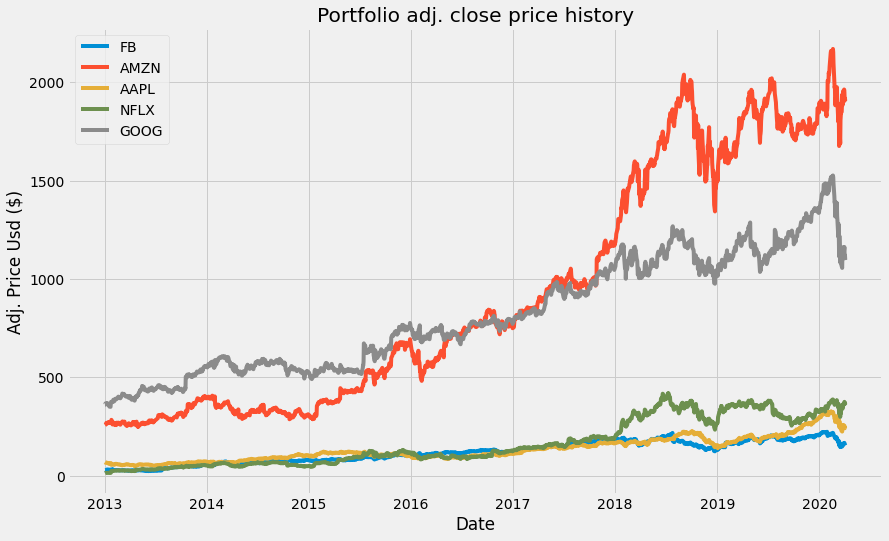

In [9]:
#Visualize portfolio
my_stocks = df
title = 'Portfolio adj. close price history'
plt.figure(figsize=(13, 8))
for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label = c)
plt.title(title)
plt.xlabel('Date')
plt.ylabel('Adj. Price Usd ($)')
plt.legend(my_stocks.columns.values, loc='upper left')
plt.show()

In [10]:
#Show the daily simple return
returns = df.pct_change()
returns

,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.008214,0.004547,-0.012623,0.049777,0.000581
2013-01-04,0.035650,0.002592,-0.027855,-0.006315,0.019760
2013-01-07,0.022949,0.035925,-0.005882,0.033549,-0.004363
2013-01-08,-0.012237,-0.007748,0.002691,-0.020565,-0.001974
...,...,...,...,...,...
2020-03-30,0.058422,0.033603,0.028538,0.038754,0.032511
2020-03-31,0.005122,-0.007246,-0.002041,0.012239,0.013943
2020-04-01,-0.043165,-0.021552,-0.052617,-0.030413,-0.049183


In [11]:
#Show the annualized covariance matrix
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,FB,AMZN,AAPL,NFLX,GOOG
FB,0.114491,0.050869,0.038910,0.054245,0.046454
AMZN,0.050869,0.090363,0.034173,0.060009,0.045432
AAPL,0.038910,0.034173,0.075230,0.031022,0.035434
NFLX,0.054245,0.060009,0.031022,0.214486,0.048537
GOOG,0.046454,0.045432,0.035434,0.048537,0.062798


In [12]:
#Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.057901420147660705

In [13]:
#Calculate the portfolio volatility (STD)
port_volatility = np.sqrt(port_variance)
port_volatility

0.24062713925835694

In [14]:
#Calculate the annual portfolio return
portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
portfolioSimpleAnnualReturn

0.31419374854180565

In [15]:
#Expected annual return, volatility (risk) and variance
percent_var = str(round(port_variance, 2) * 100) + ' %'
percent_vols = str(round(port_volatility, 2) * 100) + ' %'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2) * 100) + ' %'

print('Expected annual return: '+ percent_ret)
print('Annual volatility: '+ percent_vols)
print('Annual variance: '+ percent_var)

Expected annual return: 31.0 %
Annual volatility: 24.0 %
Annual variance: 6.0 %


In [17]:
#Portfolio optimization

#Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

#Optimize for max sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

{'FB': 0.11976, 'AMZN': 0.31495, 'AAPL': 0.17312, 'NFLX': 0.39217, 'GOOG': 0.0}
Expected annual return: 39.3%
Annual volatility: 28.1%
Sharpe Ratio: 1.33


(0.39288447996406994, 0.28134711982802807, 1.3253538198364838)

In [19]:
#Get the discrete allocation of each share per stock
latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=15000)

allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Discrete allocation: {'FB': 13.0, 'AMZN': 2.0, 'AAPL': 11.0, 'NFLX': 17.0}
Funds remaining: $377.05
